In [1]:
import os
import re
from glob import glob
import pathlib
from pathlib import Path
import random
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image
import idp_utils.data_handling.constants as C

%cd $C.ROOT_PATH

seed = 6
random.seed(seed)
np.random.seed(seed)

/home/extra/micheal/IDP


# 1 Prepare Fake Labels & Fake Scans

In [22]:
OP_split_path = C.SPLIT_PATTERN.format(data='OP', name='original')
AROI_split_path = C.SPLIT_PATTERN.format(data='AROI', name='hetero')

OP_test_bscan_path = os.path.join(OP_split_path, 'bscans', 'test')
OP_test_label_path = os.path.join(OP_split_path, 'labels', 'test')
AROI_test_bscan_path = os.path.join(AROI_split_path, 'bscans', 'test')
AROI_test_label_path = os.path.join(AROI_split_path, 'labels', 'test')

num_test_OP = len(os.listdir(OP_test_bscan_path))
num_test_AROI = len(os.listdir(AROI_test_bscan_path))
print('num of test in op:', num_test_OP)
print('num of test in aroi:', num_test_AROI)

num of test in op: 4153
num of test in aroi: 109


In [23]:
OP_label_sample_name = os.listdir(OP_test_label_path)[0]
OP_bscan_sample_name = os.listdir(OP_test_bscan_path)[0]
assert OP_label_sample_name == OP_bscan_sample_name
AROI_label_sample_name = os.listdir(AROI_test_label_path)[0]
AROI_bscan_sample_name = os.listdir(AROI_test_bscan_path)[0]
assert AROI_bscan_sample_name == AROI_label_sample_name

OP_bscan_shape = np.asarray(Image.open(os.path.join(OP_test_bscan_path, OP_bscan_sample_name))).shape
OP_label_shape  = np.asarray(Image.open(os.path.join(OP_test_label_path, OP_label_sample_name))).shape
assert OP_bscan_shape == OP_label_shape
print(f'OP bscan shape: {OP_bscan_shape}')
AROI_bscan_shape = np.asarray(Image.open(os.path.join(AROI_test_bscan_path, AROI_bscan_sample_name))).shape
AROI_label_shape = np.asarray(Image.open(os.path.join(AROI_test_label_path, AROI_label_sample_name))).shape
assert AROI_bscan_shape == AROI_label_shape
print(f'AROI bscan shape: {AROI_bscan_shape}')


OP bscan shape: (1024, 512)
AROI bscan shape: (1024, 512)


In [24]:
OP_labels_with_instrument = []
for label_path in glob(os.path.join(OP_test_label_path, '*.png')):
    label = np.asarray(Image.open(label_path))
    for value in C.INSTRUMENT_LABELS:
        if np.any(label == value):
            OP_labels_with_instrument.append(label_path)
print(f'num of OP labels with instrument: {len(OP_labels_with_instrument)}')

num of OP labels with instrument: 2240


In [25]:
rng = np.random.default_rng(seed=seed)
sample_labels =rng.choice(len(OP_labels_with_instrument), num_test_AROI, replace=False)
OP_labels = np.array(OP_labels_with_instrument)[sample_labels]

AROI_labels = glob(os.path.join(AROI_test_label_path, '*.png'))

In [27]:
fake_labels = []
AROI_UNIQUE_LABELS = C.HETERO_AROI_LABELS + C.FLUID_LABELS
for i in range(num_test_AROI):
    OP_label = np.asarray(Image.open(OP_labels[i]))
    AROI_label = np.asarray(Image.open(AROI_labels[i]))
    unique_OP_labels = np.unique(AROI_label)

    # remove irrelevant labels from OP labels
    irre_OP_labels = [ label for label in np.unique(OP_label) if label not in C.INSTRUMENT_LABELS]
    for label in irre_OP_labels:
        OP_label = np.where(OP_label == label, 0, OP_label)

    fake_label = OP_label + AROI_label

    # remove labels below OP labels
    start, end = fake_label.shape[1], 0
    for col in range(fake_label.shape[1]):
        for label in C.INSTRUMENT_LABELS:
            if label in fake_label[:, col]:
                if col < start:
                    start = col
                if col > end:
                    end = col
    for col in range(start, end+1):
        for label in AROI_UNIQUE_LABELS:
            fake_label[:, col] = np.where(fake_label[:, col] == label, 0, fake_label[:, col])

    fake_labels.append(fake_label)

In [28]:
# fake_bscan = np.zeros(AROI_bscan_shape, dtype=np.uint8)
# fake_bscans = [fake_bscan] * num_test_AROI

OP_bscans = [ re.sub('labels', 'bscans', label) for label in OP_labels]
OP_bscans = [ np.asarray(Image.open(bscan)) for bscan in OP_bscans]
fake_bscans = np.asarray(OP_bscans)

In [29]:
fake_split_folder = C.SPLIT_PATTERN.format(data='OPAROI', name='fake')
pathlib.Path(os.path.join(fake_split_folder, 'labels', 'train')).mkdir(parents=True, exist_ok=True)
pathlib.Path(os.path.join(fake_split_folder, 'labels', 'val')).mkdir(parents=True, exist_ok=True)
pathlib.Path(os.path.join(fake_split_folder, 'labels', 'test')).mkdir(parents=True, exist_ok=True)
pathlib.Path(os.path.join(fake_split_folder, 'bscans', 'train')).mkdir(parents=True, exist_ok=True)
pathlib.Path(os.path.join(fake_split_folder, 'bscans', 'val')).mkdir(parents=True, exist_ok=True)
pathlib.Path(os.path.join(fake_split_folder, 'bscans', 'test')).mkdir(parents=True, exist_ok=True)

In [30]:
for i in range(num_test_AROI):
    label_img = Image.fromarray(fake_labels[i])
    bscan_img = Image.fromarray(fake_bscans[i])

    label_img.save(os.path.join(fake_split_folder, 'labels', 'test', '{}__{}.png'.format(OP_labels[i].split('/')[-1], AROI_labels[i].split('/')[-1])))
    bscan_img.save(os.path.join(fake_split_folder, 'bscans', 'test', '{}__{}.png'.format(OP_labels[i].split('/')[-1], AROI_labels[i].split('/')[-1])))

# 2 Generate Fake Labels Datasets

In [31]:
data, name = "OPAROI", "fake"

bscan_folder = os.path.join(C.SPLIT_PATTERN.format(data=data, name=name), "bscans")
label_folder = os.path.join(C.SPLIT_PATTERN.format(data=data, name=name), "labels")
dataset_folder = C.DATASET_PATTERN.format(data=data, name=name)

In [32]:
!python pytorch-CycleGAN-and-pix2pix/datasets/combine_A_and_B.py \
    --fold_A "$label_folder" \
    --fold_B "$bscan_folder" \
    --fold_AB "$dataset_folder" 

[fold_A] =  data/splits/OPAROI/fake/labels
[fold_B] =  data/splits/OPAROI/fake/bscans
[fold_AB] =  data/datasets/OPAROI/fake
[num_imgs] =  1000000
[use_AB] =  False
[no_multiprocessing] =  False
split = train, use 0/0 images
split = train, number of images = 0
split = test, use 109/109 images
split = test, number of images = 109
split = val, use 0/0 images
split = val, number of images = 0


# 3 Test

In [33]:
data, name = "OPAROI", "fake"
dataset_folder = C.DATASET_PATTERN.format(data=data, name=name)
checkpoint_name = 'oparoi_heterolabel_pix2pix'

!python pytorch-CycleGAN-and-pix2pix/test.py \
        --dataroot $dataset_folder \
        --direction AtoB \
        --name $checkpoint_name \
        --model pix2pix \
        --num_test $num_test_AROI 

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: data/datasets/OPAROI/fake     	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

# 4 Visualization

In [2]:
AROI_split_path = C.SPLIT_PATTERN.format(data='AROI', name='hetero')
AROI_test_bscan_path = os.path.join(AROI_split_path, 'bscans', 'test')

In [3]:
checkpoint_name = 'oparoi_heterolabel_pix2pix'
img_sample_folder = os.path.join('results', checkpoint_name, 'test_latest', 'images')
imgs = glob(os.path.join(img_sample_folder, '*.png'))
imgs_fakeB = []
for img in imgs:
    img_name = img.split('/')[-1]
    if 'fake_B' in img_name:
        imgs_fakeB.append(img)

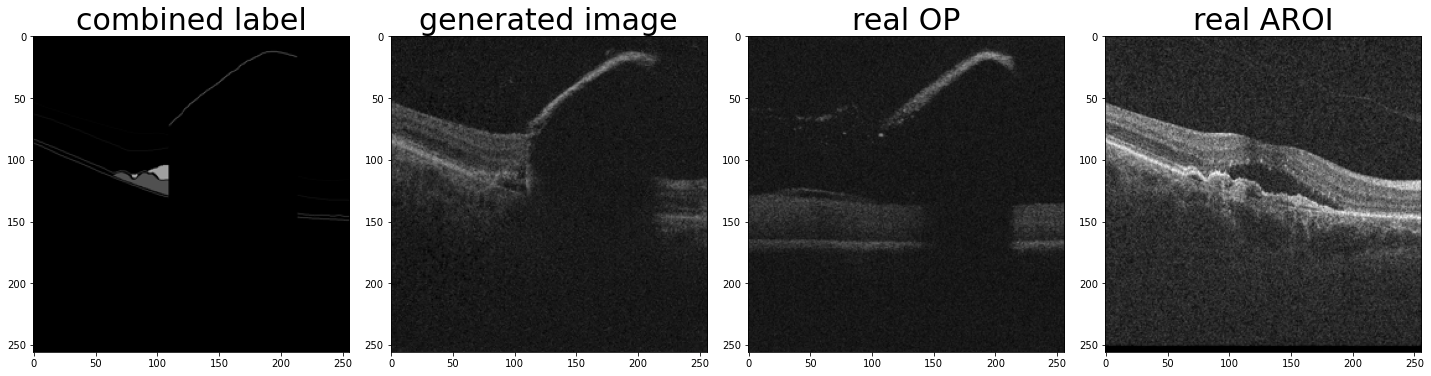

In [9]:
rand_idx = random.randint(0, len(imgs_fakeB))
fake_B_sample_path = imgs_fakeB[rand_idx]

AROI_file = fake_B_sample_path.split('/')[-1].split('__')[-1].split()[0]

fake_B_sample = np.asarray(Image.open(fake_B_sample_path))
real_A_sample = np.asarray(Image.open(re.sub('fake_B', 'real_A', fake_B_sample_path)))
real_OP_sample = np.asarray(Image.open(re.sub('fake_B', 'real_B', fake_B_sample_path)))
AROI_resize_shape = (fake_B_sample.shape[0], fake_B_sample.shape[1])
real_AROI_sample = np.asarray(Image.open(os.path.join(AROI_test_bscan_path, AROI_file)).resize(AROI_resize_shape))

fig, axs = plt.subplots(1, 4, figsize=(20, 8))
axs[0].imshow(real_A_sample)
axs[0].set_title('combined label', fontsize=30)
axs[1].imshow(fake_B_sample)
axs[1].set_title('generated image', fontsize=30)
axs[2].imshow(real_OP_sample)
axs[2].set_title('real OP', fontsize=30)
axs[3].imshow(real_AROI_sample, cmap='gray')
axs[3].set_title('real AROI', fontsize=30)

plt.tight_layout()